I/O FEATURE VISUALIZATION UNDER MEMORY STRESS


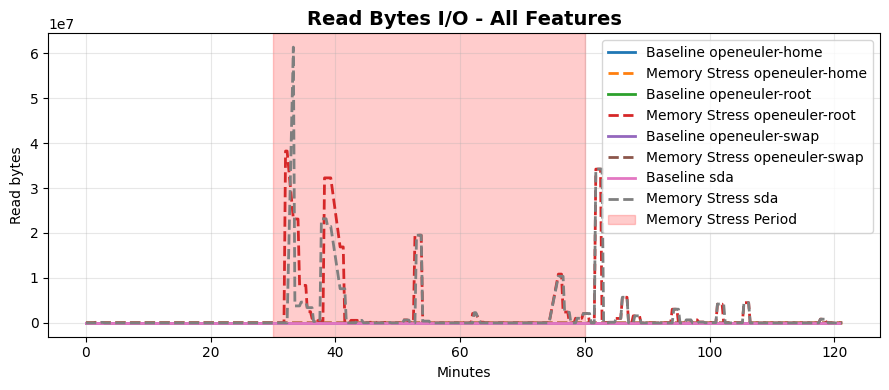

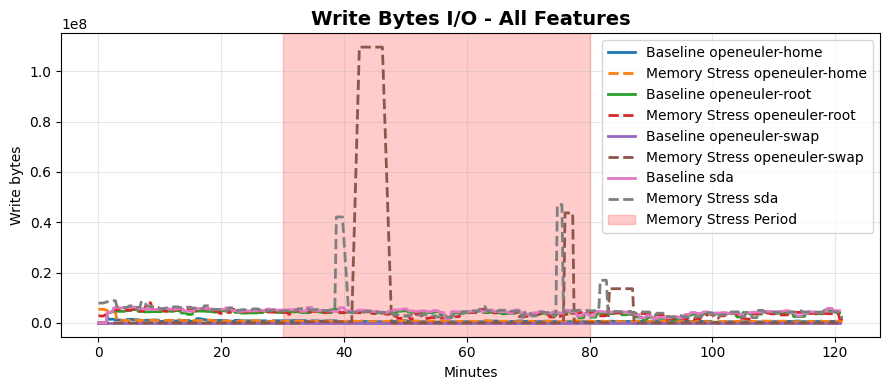


I/O PERFORMANCE UNDER MEMORY STRESS ANALYSIS


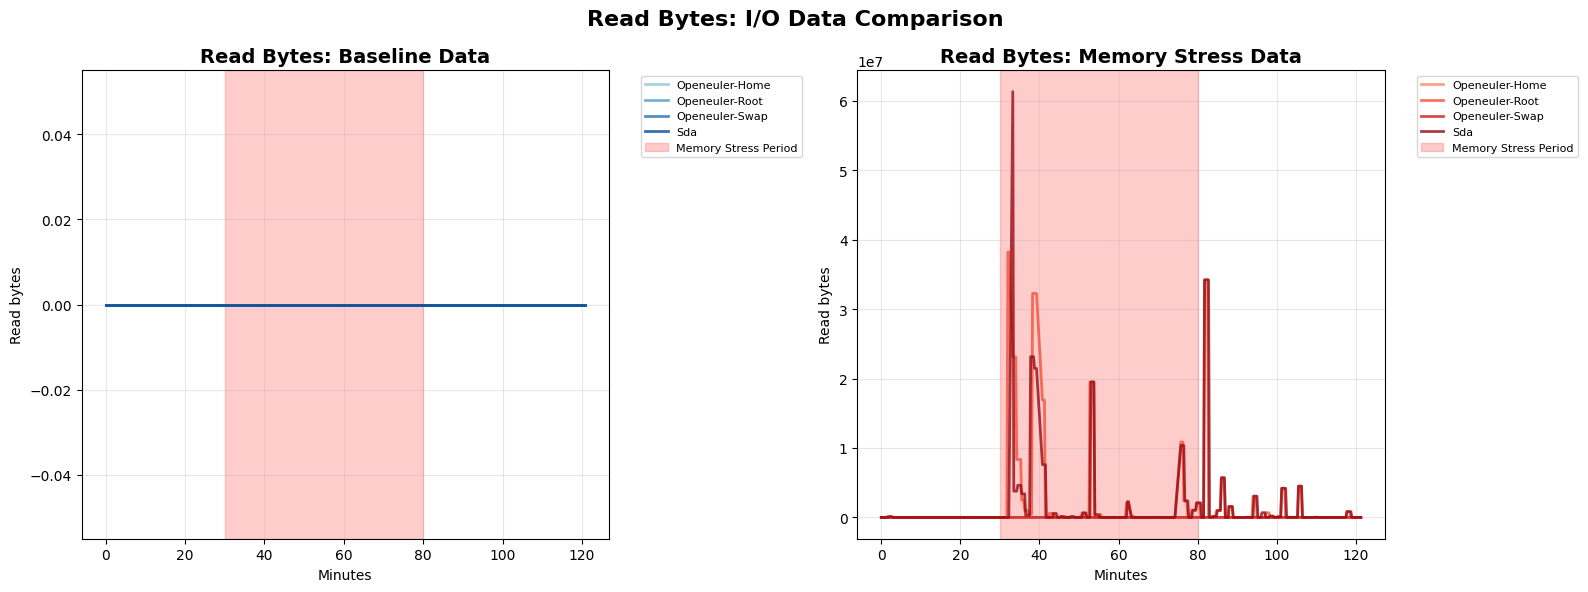

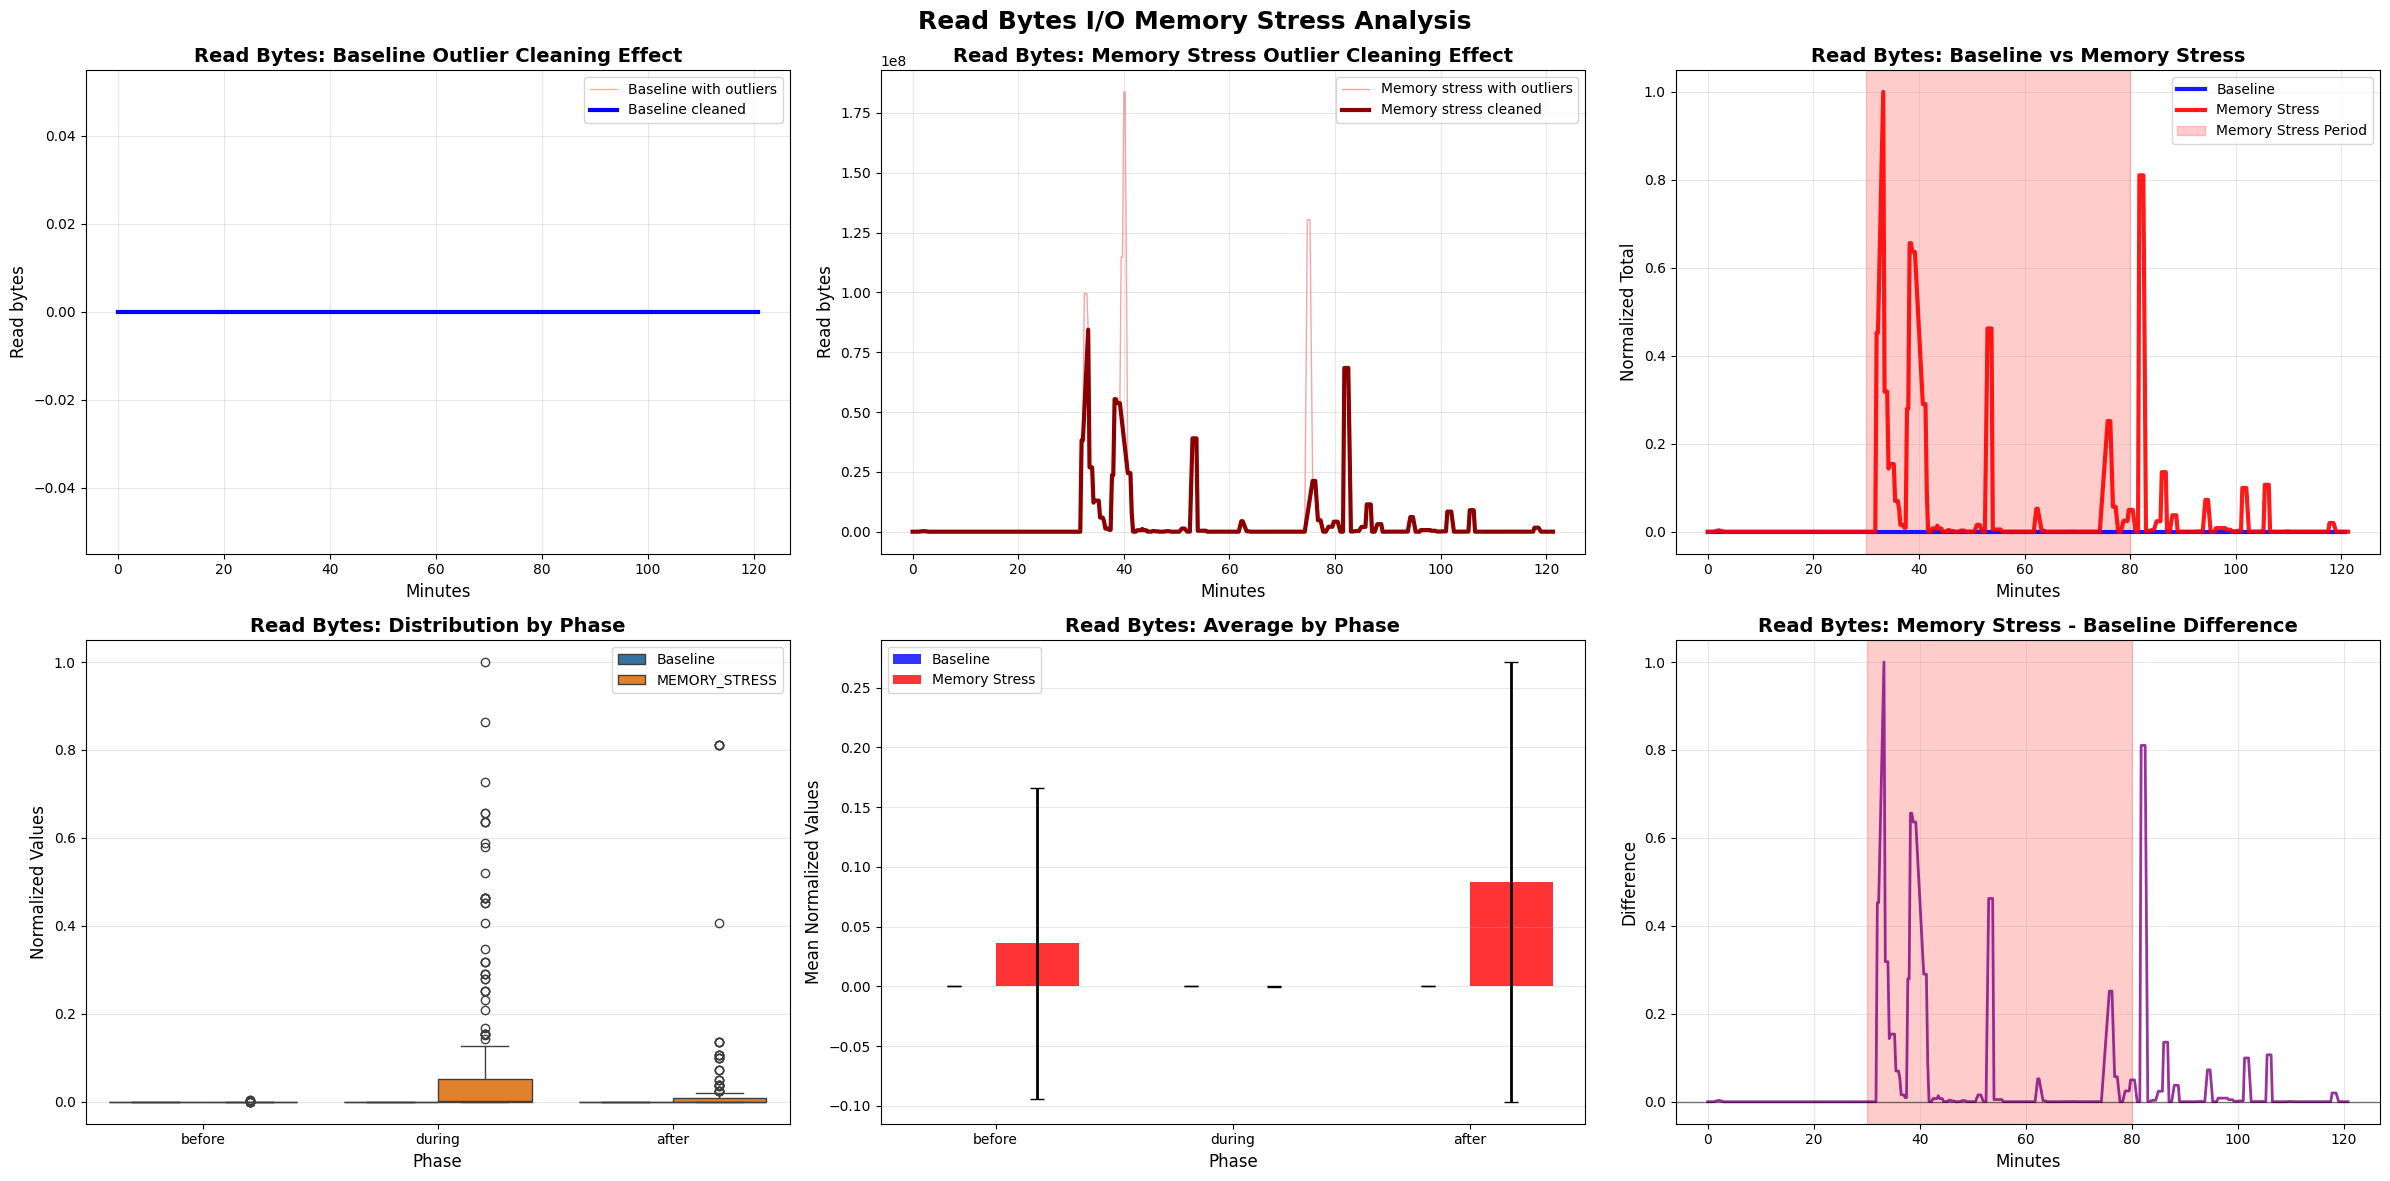


READ BYTES - I/O MEMORY STRESS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0    0    0
before   0.0  0.0    0    0
during   0.0  0.0    0    0

MEMORY STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0362  0.1300  0.0001  0.8104
before  0.0001  0.0005  0.0000  0.0030
during  0.0875  0.1840  0.0000  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.48, p=  0.0139 SIGNIFICANT
  DURING  : t= -6.75, p=  0.0000 SIGNIFICANT
  AFTER   : t= -3.58, p=  0.0004 SIGNIFICANT

MEMORY STRESS IMPACT ON I/O:
  BEFORE  :    +inf% INCREASE
  DURING  :    +inf% INCREASE
  AFTER   :    +inf% INCREASE


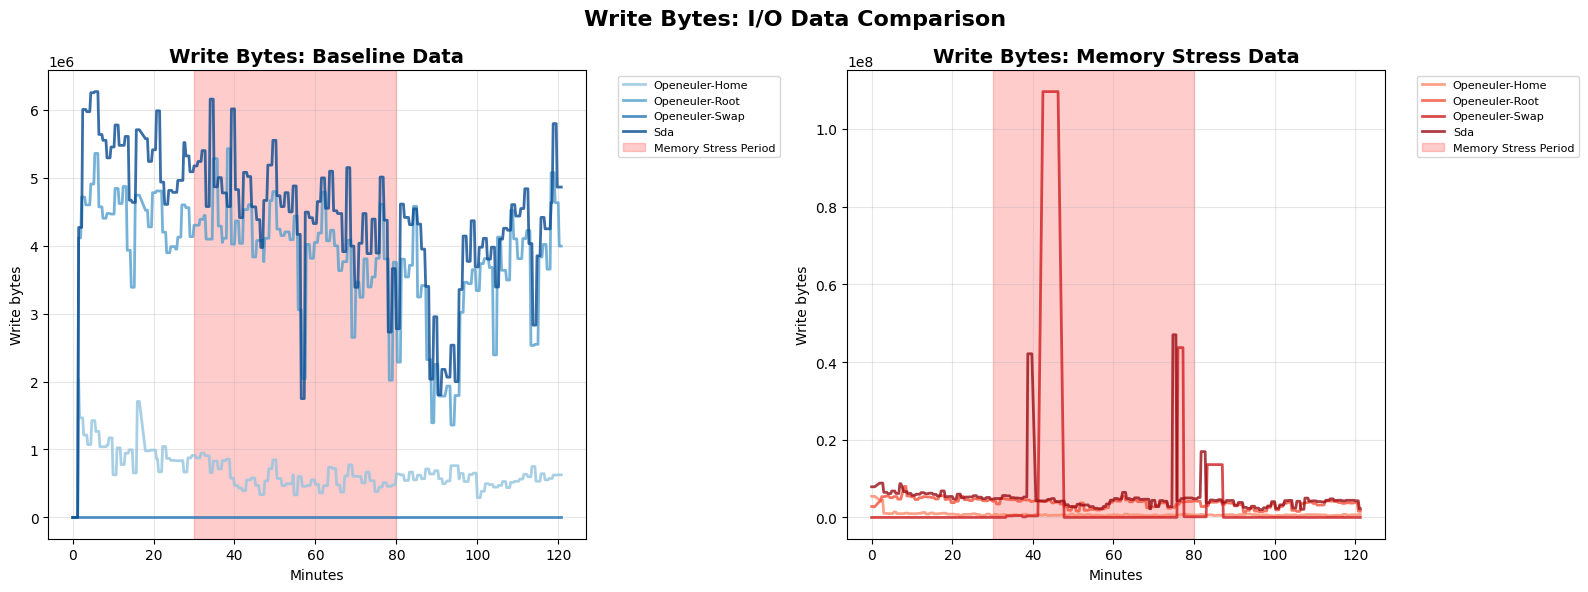

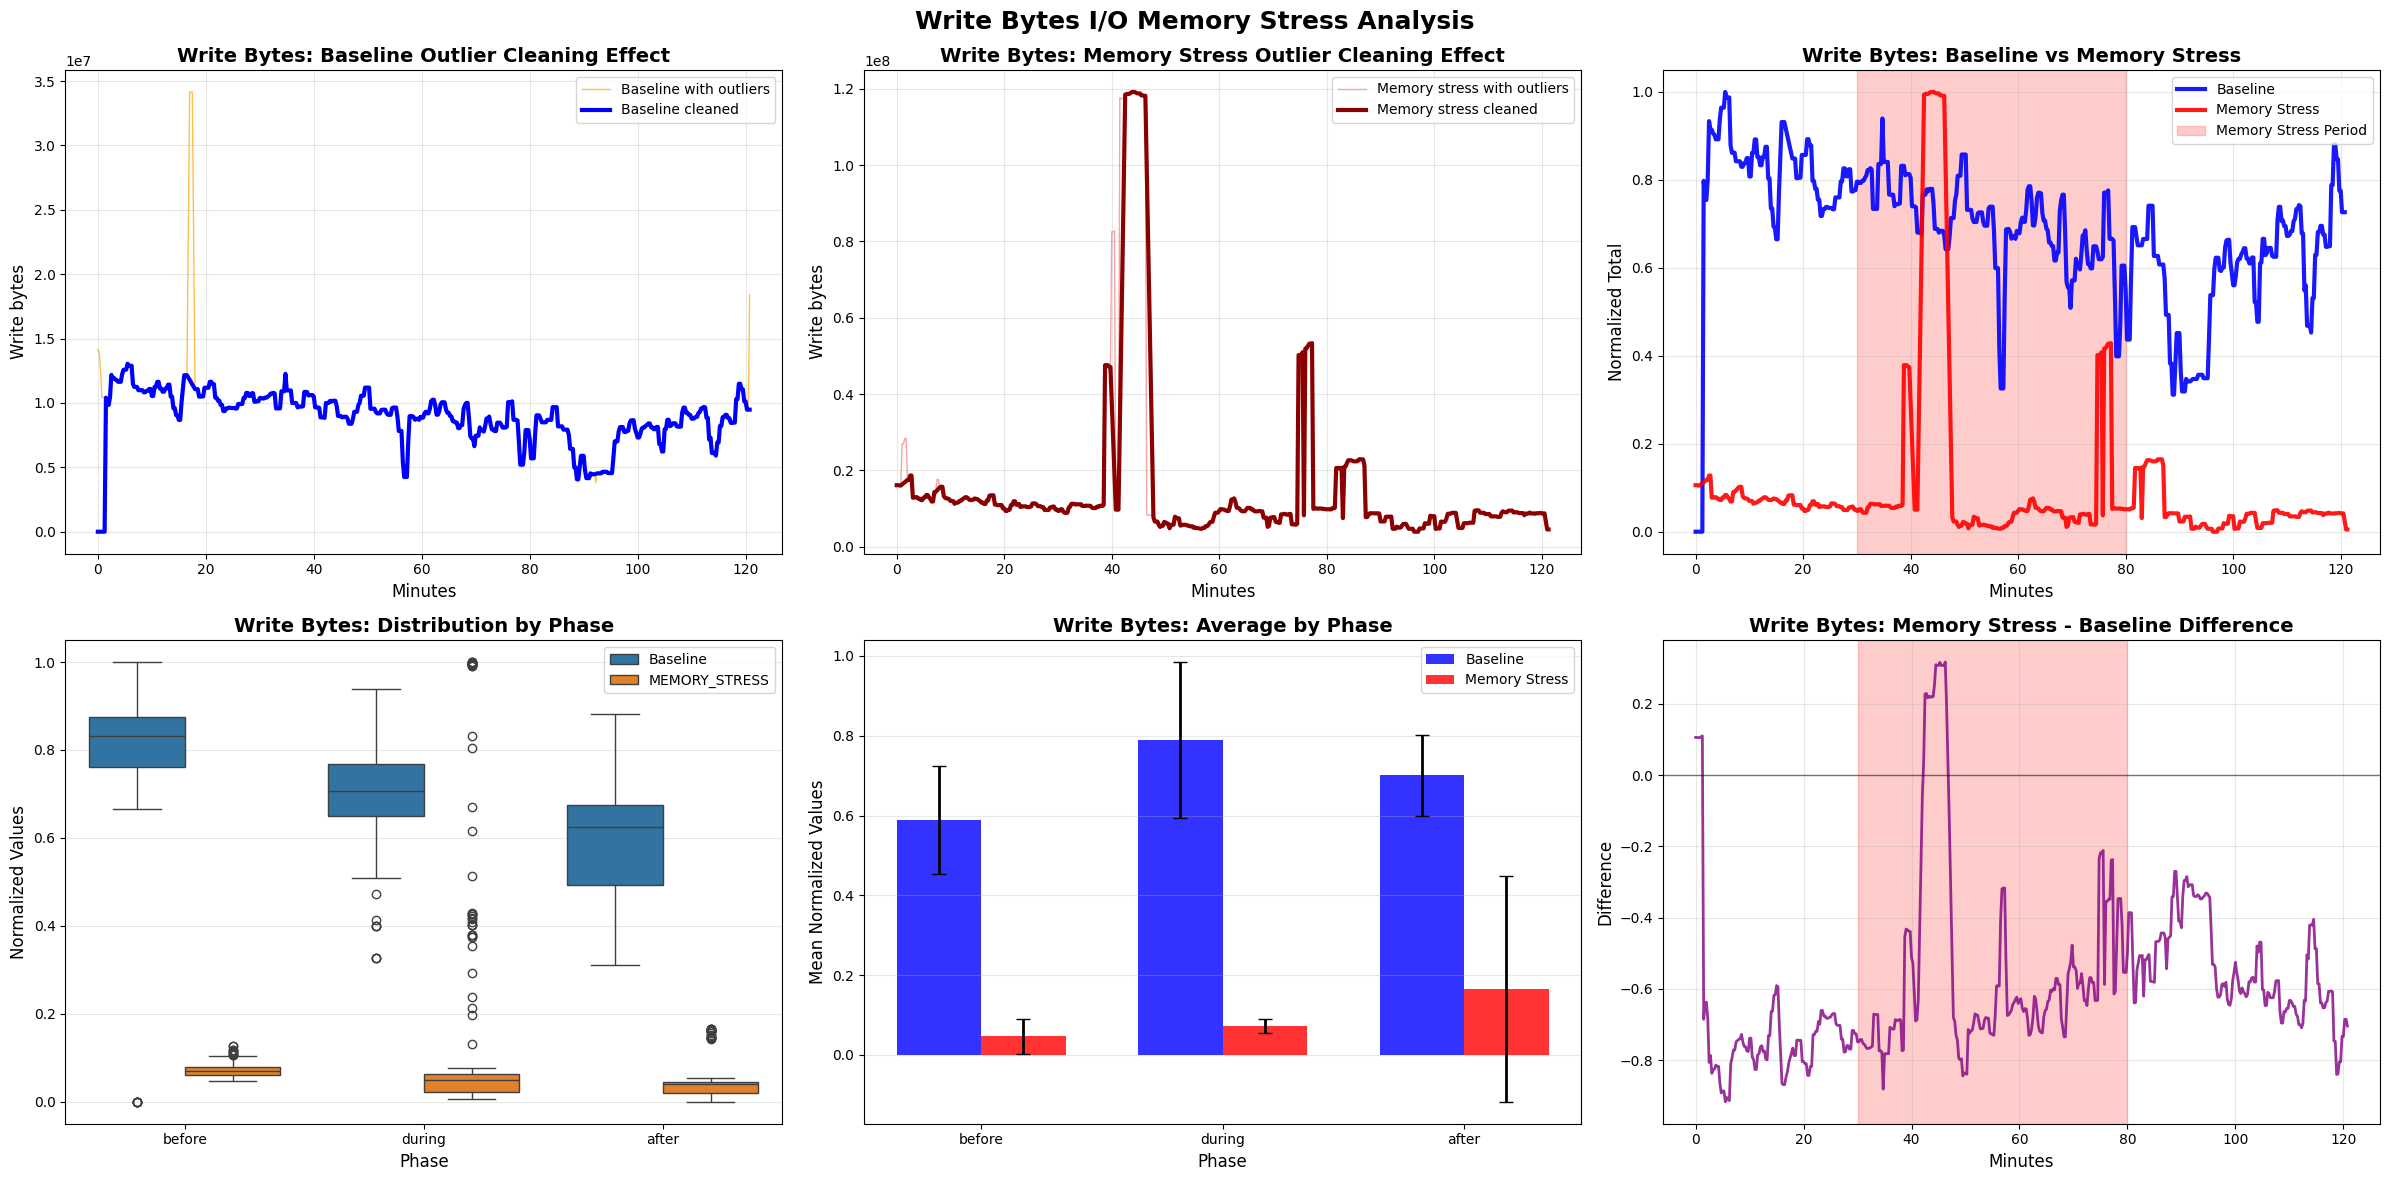


WRITE BYTES - I/O MEMORY STRESS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5885  0.1347  0.3117  0.8807
before  0.7895  0.1952  0.0000  1.0000
during  0.7008  0.1011  0.3258  0.9397

MEMORY STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0464  0.0444  0.0000  0.1647
before  0.0726  0.0181  0.0473  0.1278
during  0.1660  0.2832  0.0066  1.0000

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 40.06, p=  0.0000 SIGNIFICANT
  DURING  : t= 25.21, p=  0.0000 SIGNIFICANT
  AFTER   : t= 48.76, p=  0.0000 SIGNIFICANT

MEMORY STRESS IMPACT ON I/O:
  BEFORE  :  -90.80% DECREASE
  DURING  :  -76.31% DECREASE
  AFTER   :  -92.11% DECREASE


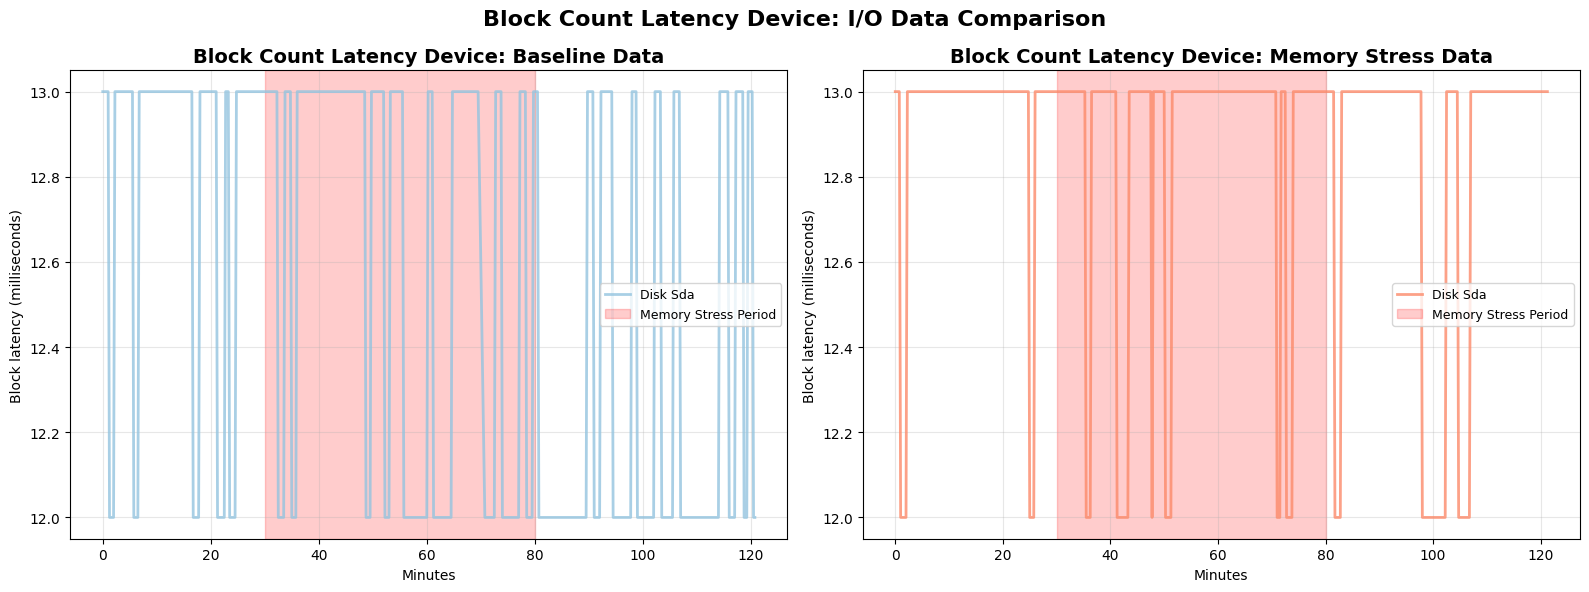

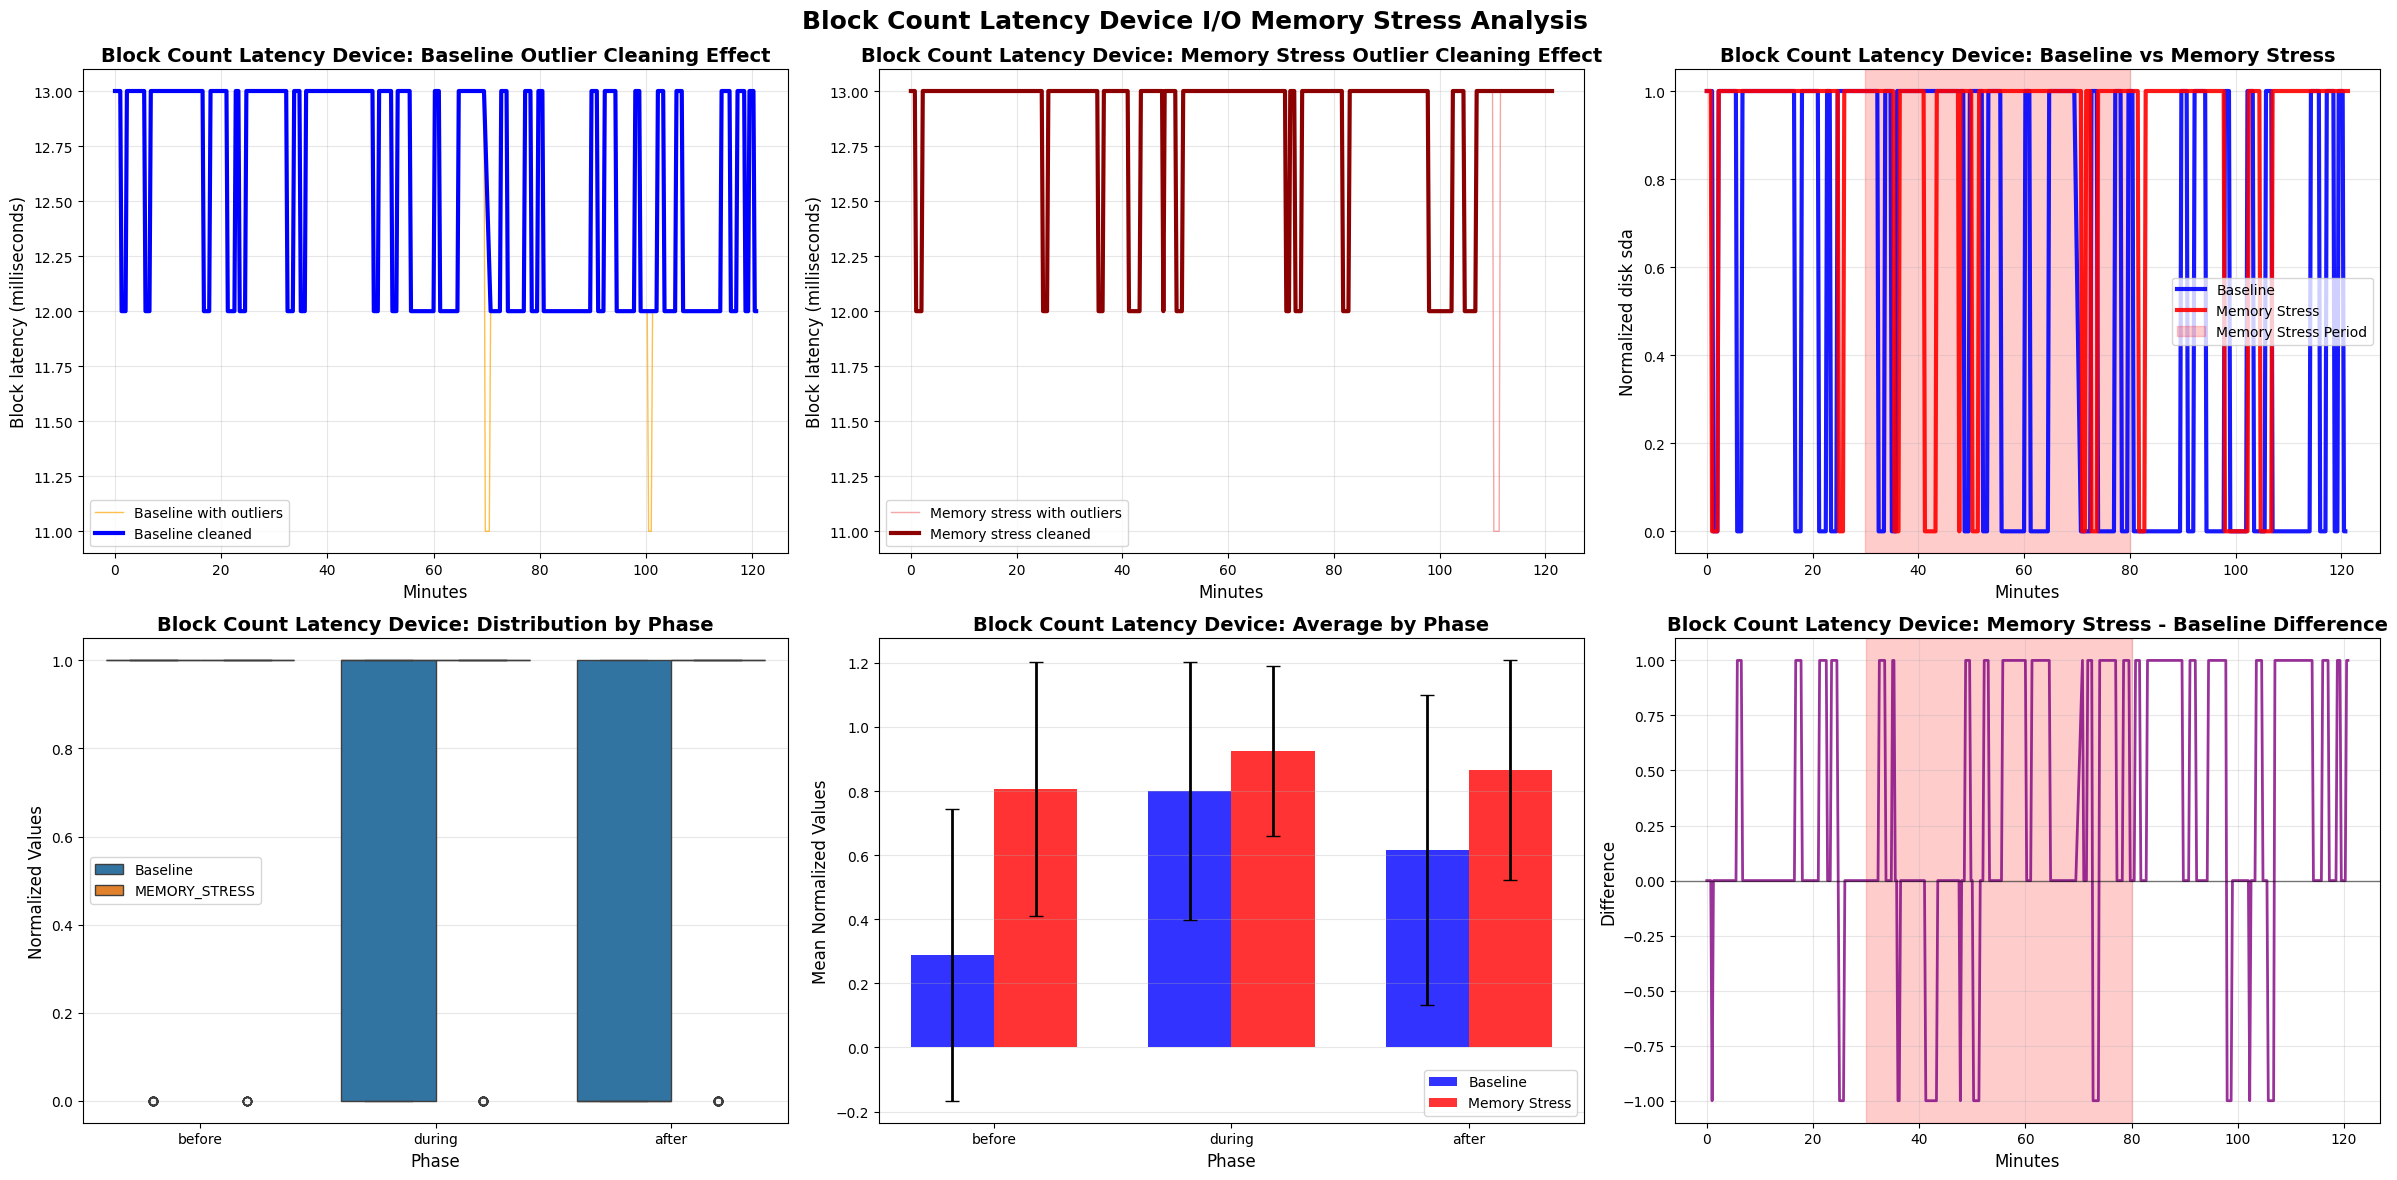


BLOCK COUNT LATENCY DEVICE - I/O MEMORY STRESS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.2883  0.4544  0.0  1.0
before  0.8000  0.4017  0.0  1.0
during  0.6169  0.4832  0.0  1.0

MEMORY STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8061  0.3966  0.0  1.0
before  0.9250  0.2645  0.0  1.0
during  0.8657  0.3419  0.0  1.0

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -2.85, p=  0.0048 SIGNIFICANT
  DURING  : t= -5.96, p=  0.0000 SIGNIFICANT
  AFTER   : t=-10.89, p=  0.0000 SIGNIFICANT

MEMORY STRESS IMPACT ON I/O:
  BEFORE  :  +15.62% INCREASE
  DURING  :  +40.32% INCREASE
  AFTER   : +179.55% INCREASE


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all IO datasets
df_block_count_latency_device = pd.read_csv("block_count_latency_device.csv")
df_read_bytes = pd.read_csv("read_bytes.csv")
df_write_bytes = pd.read_csv("write_bytes.csv")

df_baseline_block_count_latency_device = pd.read_csv("../../baseline/IO related/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("../../baseline/IO related/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("../../baseline/IO related/write_bytes.csv")

# Add source labels for tracking
df_block_count_latency_device["source"] = "MEMORY_STRESS"
df_read_bytes["source"] = "MEMORY_STRESS"
df_write_bytes["source"] = "MEMORY_STRESS"

df_baseline_block_count_latency_device["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Convert to datetime
datasets = [
    df_block_count_latency_device, df_read_bytes, df_write_bytes,
    df_baseline_block_count_latency_device, df_baseline_read_bytes, df_baseline_write_bytes
]

for df in datasets:
    df["Time"] = pd.to_datetime(df["Time"])

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_block_count_latency_device["Time"].min() - df_block_count_latency_device["Time"].min()
df_block_count_latency_device["Time"] += time_offset
df_read_bytes["Time"] += time_offset
df_write_bytes["Time"] += time_offset

# Create Minutes column for all datasets
for df in datasets:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

# Store original datasets before cleaning
original_datasets = {
    'Read Bytes': {
        'baseline': df_baseline_read_bytes.copy(),
        'memorystress': df_read_bytes.copy()
    },
    'Write Bytes': {
        'baseline': df_baseline_write_bytes.copy(),
        'memorystress': df_write_bytes.copy()
    },
    'Block Count Latency Device': {
        'baseline': df_baseline_block_count_latency_device.copy(),
        'memorystress': df_block_count_latency_device.copy()
    }
}

# Isolation Forest outlier detection 
def remove_outliers_isolation_forest_io(df, contamination=0.03):
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get numeric columns
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Apply Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each numeric column
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# Apply outlier cleaning
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        df_clean, stats = remove_outliers_isolation_forest_io(df, contamination=0.03)
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats

# Normalization function
def normalize_df_io(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Add phase column 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# Get appropriate y-axis label based on dataset type
def get_y_label(dataset_name):
    if 'read' in dataset_name.lower() and 'bytes' in dataset_name.lower():
        return 'Read bytes'
    elif 'write' in dataset_name.lower() and 'bytes' in dataset_name.lower():
        return 'Write bytes'
    elif 'latency' in dataset_name.lower() or 'block' in dataset_name.lower():
        return 'Block latency (milliseconds)'
    else:
        return 'Value'

# Plot original I/O data
def plot_original_io_data(dataset_name, memorystress_df, baseline_df, delay_minutes, duration_minutes):
    # Get all numeric columns except Time, Minutes
    numeric_cols = [col for col in memorystress_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return
    
    # Limit the number of columns to show for readability
    max_cols_to_show = 5
    if len(numeric_cols) > max_cols_to_show:
        display_cols = numeric_cols[:max_cols_to_show]
    else:
        display_cols = numeric_cols
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        short_name = col.replace('_', ' ').title()[:15]
        ax1.plot(baseline_df['Minutes'], baseline_df[col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=short_name)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline Data', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel(y_label)
    ax1.grid(True, alpha=0.3)
    
    if len(display_cols) <= 3:
        ax1.legend(loc='best', fontsize=9)
    else:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Memory Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        short_name = col.replace('_', ' ').title()[:15]
        ax2.plot(memorystress_df['Minutes'], memorystress_df[col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=short_name)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    ax2.set_title(f'{dataset_name}: Memory Stress Data', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel(y_label)
    ax2.grid(True, alpha=0.3)
    
    if len(display_cols) <= 3:
        ax2.legend(loc='best', fontsize=9)
    else:
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.suptitle(f'{dataset_name}: I/O Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Enhanced analysis and plot function
def analyze_and_plot_io_dataset_wide(dataset_name, memorystress_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    
    plot_original_io_data(dataset_name, memorystress_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Get original datasets for comparison
    memorystress_df_original = original_datasets[dataset_name]['memorystress']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    # Get numeric columns
    numeric_cols = [col for col in memorystress_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if not numeric_cols:
        return None
    
    # If multiple columns, create Total column, otherwise use the main column
    if len(numeric_cols) > 1:
        memorystress_df_clean['Total'] = memorystress_df_clean[numeric_cols].sum(axis=1)
        baseline_df_clean['Total'] = baseline_df_clean[numeric_cols].sum(axis=1)
        memorystress_df_original['Total'] = memorystress_df_original[numeric_cols].sum(axis=1)
        baseline_df_original['Total'] = baseline_df_original[numeric_cols].sum(axis=1)
        main_metric = 'Total'
    else:
        main_metric = numeric_cols[0]
    
    memorystress_norm = normalize_df_io(memorystress_df_clean, [main_metric])
    baseline_norm = normalize_df_io(baseline_df_clean, [main_metric])
    
    memorystress_norm = add_phase_column(memorystress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_memorystress = memorystress_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'MEMORY_STRESS': memorystress_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': memorystress_norm[main_metric] - baseline_norm[main_metric]
    })
    
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['MEMORY_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        memorystress_mean = stats_memorystress.loc[phase, 'mean']
        impact[phase] = ((memorystress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Comprehensive analysis plotting
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_metric], 
             label='Baseline with outliers', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_metric], 
             label='Baseline cleaned', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Memory stress outlier cleaning effect 
    plt.subplot(2, 3, 2)
    plt.plot(memorystress_df_original['Minutes'], memorystress_df_original[main_metric], 
             label='Memory stress with outliers', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(memorystress_df_clean['Minutes'], memorystress_df_clean[main_metric], 
             label='Memory stress cleaned', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: Memory Stress Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(memorystress_norm['Minutes'], memorystress_norm[main_metric], 
             label='Memory Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    plt.title(f"{dataset_name}: Baseline vs Memory Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'MEMORY_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_memorystress['mean'], width, label='Memory Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_memorystress['mean'], yerr=stats_memorystress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Memory Stress - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} I/O Memory Stress Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{dataset_name.upper()} - I/O MEMORY STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\nBASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\nMEMORY STRESS STATISTICS BY PHASE:")
    print(stats_memorystress.round(4))
    
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} {sig}")
    
    print(f"\nMEMORY STRESS IMPACT ON I/O:")
    for phase, change in impact.items():
        direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% {direction}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_memorystress': stats_memorystress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric,
        'numeric_columns': numeric_cols
    }

# Plot all features together
def plot_features_together(baseline_df, memorystress_df, dataset_name, delay=30, duration=50):
    numeric_cols = [col for col in baseline_df.columns 
                   if col not in ['Time', 'Minutes', 'source', 'phase'] and 
                   baseline_df[col].dtype in ['int64', 'float64']]
    
    if not numeric_cols:
        return
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    plt.figure(figsize=(9, 4))
    
    for col in numeric_cols:
        plt.plot(baseline_df['Minutes'], baseline_df[col], 
                label=f'Baseline {col}', linewidth=2, linestyle='-')
        plt.plot(memorystress_df['Minutes'], memorystress_df[col], 
                label=f'Memory Stress {col}', linewidth=2, linestyle='--')
    
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, 
               label='Memory Stress Period')
    
    plt.title(f'{dataset_name} I/O - All Features', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run analysis 
print("I/O FEATURE VISUALIZATION UNDER MEMORY STRESS")
print("=" * 50)
plot_features_together(datasets_clean['Read Bytes']['baseline'], datasets_clean['Read Bytes']['memorystress'], "Read Bytes")
plot_features_together(datasets_clean['Write Bytes']['baseline'], datasets_clean['Write Bytes']['memorystress'], "Write Bytes")

print("\nI/O PERFORMANCE UNDER MEMORY STRESS ANALYSIS")
print("=" * 70)

analysis_results = {}

for dataset_name in datasets_clean.keys():
    memorystress_clean = datasets_clean[dataset_name]['memorystress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_io_dataset_wide(
        dataset_name, 
        memorystress_clean, 
        baseline_clean, 
        delay, 
        duration
    )